In [10]:
import copy
import glob
import time
import random
import regex as re
import numpy as np
import pandas as pd
import datetime as dt
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
%load_ext rpy2.ipython
%run ../airquality/data/gen_daily_targets.py
%run ../airquality/data/prepare_data.py

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
test = pd.read_csv('../data/targets.csv')
stations = pd.read_csv('../data/stations.csv')
extra_features = pd.read_csv('../data/dataset_v1.csv', index_col=0).drop([
    'holiday', 'target', 
], axis=1)
rolling_mean_features = pd.read_csv('../data/data_roll_day_conc_obs.csv')
extra_features = extra_features[[c for c in extra_features.columns if not 'dist' in c]]

In [5]:
observations = pd.read_csv('../data/observations.csv', index_col=0)
models = pd.read_csv('../data/models.csv', index_col=0)
obs_and_mods = pd.merge(models, observations, how='left',
                    on=['station', 'day', 'time', 'datetime' ,'year'],
                    suffixes=('_mod', '')).sort_values('datetime', ascending=True)
obs_and_mods.to_csv('../data/obs_and_mod.csv')
obs_and_mods_cols = ['pred_0_days', 'pred_1_days', 'Concentration', 'target', 'day']
obs_and_mods.head()

,pred_0_days,pred_1_days,day,lon,lat,year,station,datetime,time,Concentration,target
0,38.79,34.11,2013-01-01,2.15,41.39,2013,ES1438A,2013-01-01 00:00:00,00:00:00,nan,nan
1,28.53,27.48,2013-01-01,2.13,41.38,2013,ES1396A,2013-01-01 00:00:00,00:00:00,nan,nan
2,35.85,42.57,2013-01-01,2.20,41.40,2013,ES0691A,2013-01-01 00:00:00,00:00:00,nan,nan
3,31.81,31.59,2013-01-01,2.15,41.40,2013,ES1480A,2013-01-01 00:00:00,00:00:00,nan,nan
4,31.81,31.59,2013-01-01,2.15,41.43,2013,ES1856A,2013-01-01 00:00:00,00:00:00,nan,nan


In [6]:
agg_types = ['mean', 'max', 'std']
tall_series = obs_and_mods.groupby(['day', 'station']).agg({
    'Concentration': agg_types
})['Concentration'].reset_index()
aggs = [tall_series.pivot(index='day', columns='station', values=agg) for agg in agg_types]
aggs = [df.rename(columns={c: c + '_' + agg for c in df.columns}) for df, agg in zip(aggs, agg_types)]
wide_series = pd.concat(aggs, axis=1)
wide_series.head()

station,ES0691A_mean,ES1396A_mean,ES1438A_mean,ES1480A_mean,ES1679A_mean,ES1856A_mean,ES1992A_mean,ES0691A_max,ES1396A_max,ES1438A_max,...,ES1679A_max,ES1856A_max,ES1992A_max,ES0691A_std,ES1396A_std,ES1438A_std,ES1480A_std,ES1679A_std,ES1856A_std,ES1992A_std
day,,,,,,,,,,,,,,,,,,,,,
2013-01-01,42.39,38.61,51.39,43.87,37.13,14.78,23.35,72.00,98.00,112.00,...,69.00,39.00,68.00,18.13,26.67,25.73,24.63,20.29,10.99,21.15
2013-01-02,52.50,47.58,63.71,54.50,48.75,32.08,43.29,87.00,86.00,119.00,...,76.00,77.00,85.00,16.61,24.72,26.48,19.18,16.91,25.43,26.53
2013-01-03,64.62,54.62,74.04,64.17,49.25,38.88,49.04,119.00,85.00,117.00,...,78.00,94.00,110.00,22.69,19.05,22.87,21.70,14.87,22.17,31.43
2013-01-04,54.12,44.30,44.50,89.13,61.92,22.18,39.04,80.00,113.00,123.00,...,108.00,60.00,99.00,16.58,28.35,32.46,45.41,25.83,16.98,28.20
2013-01-05,36.88,39.17,nan,89.00,64.00,12.25,33.54,60.00,114.00,nan,...,114.00,16.00,85.00,11.00,22.21,nan,21.63,17.04,2.56,17.75


In [7]:
test.station.unique()

array(['ES0691A', 'ES1396A', 'ES1438A', 'ES1480A', 'ES1679A', 'ES1856A',
       'ES1992A'], dtype=object)

## Cross Validation
Changes from `Jonas_5`:
* Add Jose's rolling mean features

In [118]:
data = pd.read_csv('../data/data_roll_day_dist.csv', index_col=0)

In [119]:
X = data.loc[pd.to_datetime(data['day']) < '2015-01-01'].drop(['station', 'day', 'date'], axis=1).values
y = data.loc[pd.to_datetime(data['day']) < '2015-01-01', 'conc_obs'] > 100

In [120]:
pred_lstm = pd.read_csv('../data/predictions_LSTM.csv', index_col=0)
pred_lstm.head()

,ES0691A,ES1396A,ES1438A,ES1480A,ES1679A,ES1856A,ES1992A
0,64.95,76.63,84.60,96.81,61.23,72.38,92.03
1,75.95,75.95,75.95,75.95,75.95,75.95,75.95
2,86.19,84.60,88.85,83.54,78.23,76.10,91.50
3,56.66,76.63,68.67,96.28,65.48,62.65,94.16
4,72.11,72.11,72.11,72.11,72.11,72.11,72.11


In [139]:
data.shape

(7634, 2989)

In [140]:
pred_lstm.shape

(361, 7)

In [137]:
for c in pred_lstm.columns:
    data[c] = 0
    
data[c] = [0] * 3 + list([e for e in pred_lstm[c].values])

ValueError: Length of values does not match length of index

In [35]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer

lags = 25

for s in test.station.unique():
    data = wide_series[list(wide_series.reset_index().day < '2015-01-01')]
    to_lag = data[[c for c in data.columns if not c in ['{}_{}'.format(s, agg) for agg in agg_types]]]
    features = create_lagged_features(to_lag, lags)\
        .join(extra_features[extra_features.station == s].set_index('date'))\
        .join(rolling_mean_features[rolling_mean_features.station == s]
              .set_index('date').drop(['station', 'max_conc_obs'], axis=1))\
        .join(obs_and_mods[obs_and_mods.station == s][['Concentration', 'day']].groupby('day').max())
    X = features[[c for c in features.columns if not c in [
        'time', 'datetime', 'Concentration', 'target', 'station'
    ]]].values
    y = features['Concentration'].fillna(method='ffill').values

    params = pd.DataFrame({
        'eta': random.sample(list(np.linspace(0.01, 2, 201)), 200),
        'n_estimators': random.sample(list(range(1, 250)), 200),
        'reg_alpha': random.sample(list(np.linspace(0.01, 1, 201)), 200),
        'max_depth': random.sample(list(range(1, 35)), 25) * 8,
        'score': [np.nan] * 200
    })
    for i, r in params[['eta', 'n_estimators', 'reg_alpha', 'max_depth']].head(10).iterrows():
        kf = KFold(n_splits=3)
        metric = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            p = dict(r)
            p['n_estimators'] = int(p['n_estimators'])
            p['max_depth'] = int(p['max_depth'])
            model = xgb.XGBRegressor(**p)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            metric.append(
                mean_squared_error(y_test, y_pred)
            ) 

        params.loc[i, 'score'] = np.mean(metric)
        print(params.iloc[i])

    params.to_csv('../reports/cv_xgb_Jonas_6_{}_{}.csv'
                  .format(s, len(glob.glob('../reports/cv_xgb_Jonas_6_{}_*'.format(s)))))
    params.sort_values('score').head()

eta              0.84
max_depth       13.00
n_estimators    21.00
reg_alpha        0.34
score          109.41
Name: 0, dtype: float64
eta             0.59
max_depth       4.00
n_estimators   72.00
reg_alpha       0.25
score          19.04
Name: 1, dtype: float64
eta              1.90
max_depth        1.00
n_estimators    44.00
reg_alpha        0.97
score          137.54
Name: 2, dtype: float64
eta             0.09
max_depth      21.00
n_estimators   48.00
reg_alpha       0.89
score          20.12
Name: 3, dtype: float64
eta              0.93
max_depth       22.00
n_estimators   243.00
reg_alpha        0.11
score           19.16
Name: 4, dtype: float64
eta             1.49
max_depth      19.00
n_estimators   37.00
reg_alpha       0.61
score          26.86
Name: 5, dtype: float64
eta             0.51
max_depth      18.00
n_estimators   70.00
reg_alpha       0.19
score          18.54
Name: 6, dtype: float64
eta             1.38
max_depth      26.00
n_estimators   71.00
reg_alpha       0.8

eta             0.49
max_depth      27.00
n_estimators   54.00
reg_alpha       0.43
score          39.67
Name: 2, dtype: float64
eta             0.56
max_depth       3.00
n_estimators   85.00
reg_alpha       0.69
score          34.96
Name: 3, dtype: float64
eta              1.43
max_depth       10.00
n_estimators   172.00
reg_alpha        0.10
score           41.10
Name: 4, dtype: float64
eta              1.27
max_depth       11.00
n_estimators   175.00
reg_alpha        0.76
score           41.44
Name: 5, dtype: float64
eta              0.58
max_depth        9.00
n_estimators   149.00
reg_alpha        0.25
score           40.35
Name: 6, dtype: float64
eta             0.05
max_depth      28.00
n_estimators   96.00
reg_alpha       0.14
score          40.76
Name: 7, dtype: float64
eta              0.42
max_depth       26.00
n_estimators   184.00
reg_alpha        0.15
score           41.30
Name: 8, dtype: float64
eta             0.48
max_depth      33.00
n_estimators   63.00
reg_alpha     

In [8]:
all_frames = []
for s in test.station.unique():
    frames = [pd.read_csv(f, index_col=0) for f in glob.glob('../reports/cv_xgb_Jonas_6_*{}*'.format(s))]
    try:
        frame = pd.concat(frames)
        frame['station'] = s
        all_frames.append(frame)
    except ValueError:
        pass
    
cv_results = pd.concat(all_frames)
cv_results = cv_results[cv_results['score'] > 0]
cv_results.sort_values(['score', 'station']).drop_duplicates('station')

,eta,max_depth,n_estimators,reg_alpha,score,station
6,0.51,18,70,0.19,18.54,ES0691A
9,1.72,2,222,0.81,24.07,ES1856A
2,1.06,6,40,0.59,30.97,ES1679A
3,0.56,3,85,0.69,34.96,ES1992A
4,1.64,4,107,0.06,55.69,ES1396A
9,0.46,6,227,0.69,70.77,ES1480A
9,0.78,22,189,0.09,97.92,ES1438A


In [9]:
cv_results[cv_results['station'] == 'ES0691A']

,eta,max_depth,n_estimators,reg_alpha,score,station
0,0.84,13,21,0.34,109.41,ES0691A
1,0.59,4,72,0.25,19.04,ES0691A
2,1.90,1,44,0.97,137.54,ES0691A
3,0.09,21,48,0.89,20.12,ES0691A
4,0.93,22,243,0.11,19.16,ES0691A
5,1.49,19,37,0.61,26.86,ES0691A
6,0.51,18,70,0.19,18.54,ES0691A
7,1.38,26,71,0.89,19.37,ES0691A
8,1.98,33,192,0.78,18.95,ES0691A
9,0.38,9,8,0.94,"1,129.21",ES0691A


In [75]:
test_params = []
for i, r in cv_results.sort_values(['score', 'station']).drop_duplicates('station').iterrows():
    p = dict(r)
    del p['score']
    del p['station']
    test_params.append((r['station'], p))
    
test_params

[('ES0691A',
  {'eta': 0.5075000000000001,
   'max_depth': 18,
   'n_estimators': 70,
   'reg_alpha': 0.1882}),
 ('ES1856A',
  {'eta': 1.7214, 'max_depth': 2, 'n_estimators': 222, 'reg_alpha': 0.8119}),
 ('ES1679A',
  {'eta': 1.0647, 'max_depth': 6, 'n_estimators': 40, 'reg_alpha': 0.5941}),
 ('ES1992A',
  {'eta': 0.55725,
   'max_depth': 3,
   'n_estimators': 85,
   'reg_alpha': 0.6930999999999999}),
 ('ES1396A',
  {'eta': 1.6418, 'max_depth': 4, 'n_estimators': 107, 'reg_alpha': 0.0595}),
 ('ES1480A',
  {'eta': 0.4577500000000001,
   'max_depth': 6,
   'n_estimators': 227,
   'reg_alpha': 0.6930999999999999}),
 ('ES1438A',
  {'eta': 0.77615,
   'max_depth': 22,
   'n_estimators': 189,
   'reg_alpha': 0.08919999999999999})]

In [49]:
%%time
lags = 25
preds_by_station = []
edit_wide_series = copy.deepcopy(wide_series)

for d in test['date'].unique():
    data = edit_wide_series[list(pd.to_datetime(edit_wide_series.reset_index().day) <= d)]
    for s, p in test_params:
        to_lag = data[[c for c in data.columns if not c in ['{}_{}'.format(s, agg) for agg in agg_types]]]
        X = create_lagged_features(to_lag, lags)
        X_train = np.nan_to_num(X.iloc[:-1].values)
        for agg in agg_types:
            start = time.time()
            print('Predicting {} for station {} day {}'.format(agg, s, d))
            y_train = np.nan_to_num(data['{}_{}'.format(s, agg)][:-1])
            X_test = np.nan_to_num(X.iloc[-1].values.reshape(1, X.shape[1]))
            p['n_jobs'] = 4
            model = xgb.XGBRegressor(**p)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            edit_wide_series.loc[d, '{}_{}'.format(s, agg)] = y_pred
            print('Predicted {} in {:,.2f}s'.format(y_pred, time.time() - start))

Predicting mean for station ES0691A day 2015-01-03
Predicted [ 55.21148682] in 6.81s
Predicting max for station ES0691A day 2015-01-03
Predicted [ 91.05612183] in 7.04s
Predicting std for station ES0691A day 2015-01-03
Predicted [ 18.69669724] in 7.63s
Predicting mean for station ES1856A day 2015-01-03
Predicted [ 34.20509338] in 3.42s
Predicting max for station ES1856A day 2015-01-03
Predicted [ 84.55183411] in 3.67s
Predicting std for station ES1856A day 2015-01-03
Predicted [ 21.84417725] in 3.23s
Predicting mean for station ES1679A day 2015-01-03
Predicted [ 45.00798416] in 1.84s
Predicting max for station ES1679A day 2015-01-03
Predicted [ 86.17668152] in 1.74s
Predicting std for station ES1679A day 2015-01-03
Predicted [ 17.88943291] in 1.77s
Predicting mean for station ES1992A day 2015-01-03
Predicted [ 31.74179268] in 1.84s
Predicting max for station ES1992A day 2015-01-03
Predicted [ 109.88838196] in 1.84s
Predicting std for station ES1992A day 2015-01-03
Predicted [ 21.495691

KeyboardInterrupt: 

In [16]:
wide_series_imputed_xgb = pd.read_csv('../data/wide_series_imputed_xgb.csv', index_col=0).fillna(method='ffill')
wide_series_imputed_xgb.head()

,ES0691A_mean,ES1396A_mean,ES1438A_mean,ES1480A_mean,ES1679A_mean,ES1856A_mean,ES1992A_mean,ES0691A_max,ES1396A_max,ES1438A_max,...,ES1679A_max,ES1856A_max,ES1992A_max,ES0691A_std,ES1396A_std,ES1438A_std,ES1480A_std,ES1679A_std,ES1856A_std,ES1992A_std
day,,,,,,,,,,,,,,,,,,,,,
2013-01-01,42.39,38.61,51.39,43.87,37.13,14.78,23.35,72.00,98.00,112.00,...,69.00,39.00,68.00,18.13,26.67,25.73,24.63,20.29,10.99,21.15
2013-01-02,52.50,47.58,63.71,54.50,48.75,32.08,43.29,87.00,86.00,119.00,...,76.00,77.00,85.00,16.61,24.72,26.48,19.18,16.91,25.43,26.53
2013-01-03,64.62,54.62,74.04,64.17,49.25,38.88,49.04,119.00,85.00,117.00,...,78.00,94.00,110.00,22.69,19.05,22.87,21.70,14.87,22.17,31.43
2013-01-04,54.12,44.30,44.50,89.13,61.92,22.18,39.04,80.00,113.00,123.00,...,108.00,60.00,99.00,16.58,28.35,32.46,45.41,25.83,16.98,28.20
2013-01-05,36.88,39.17,44.50,89.00,64.00,12.25,33.54,60.00,114.00,123.00,...,114.00,16.00,85.00,11.00,22.21,32.46,21.63,17.04,2.56,17.75


In [74]:
features.shape

(1095, 1523)

In [32]:
from sklearn.model_selection import  KFold
from sklearn.metrics import log_loss

lags = 25
preds_by_station = []
for s, p in test_params:
    data = pd.concat([
        wide_series[list(wide_series.reset_index().day < '2015-01-01')],
        wide_series_imputed_xgb[list(wide_series_imputed_xgb.reset_index().day >= '2015-01-01')]
    ])
    to_lag = data[[c for c in data.columns if not c in ['{}_{}'.format(s, agg) for agg in agg_types]]]
    features = create_lagged_features(to_lag, lags)\
        .join(extra_features[extra_features.station == s].set_index('date'))\
        .join(rolling_mean_features[rolling_mean_features.station == s]
              .set_index('date').drop(['station', 'max_conc_obs'], axis=1))\
        .join(obs_and_mods[obs_and_mods.station == s][['Concentration', 'day']].groupby('day').max())\
        .fillna(method='ffill').fillna(0)
    X = features[[c for c in features.columns if not c in [
        'time', 'datetime', 'Concentration', 'target', 'station'
    ]]].values
    y = (features['Concentration'].values > 100).astype(int)
    y_pred_all = copy.deepcopy(y).astype(float)
    metrics_all = []
    
    kf = KFold(n_splits=2)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        p['probability'] = True
        model = xgb.XGBClassifier(**p)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        y_pred_all[test_index] = y_pred[:, 1]
        metrics_all.append(log_loss(y_test, y_pred, labels=(0, 1)))
        
    preds_by_station.append((s, y_pred_all))

predictions = pd.DataFrame(np.column_stack([e[1] for e in preds_by_station]), columns=test.station.unique())
predictions['date'] = features.reset_index()['day']
predictions.to_csv('../reports/pred_xgb_Jonas_6_{}.csv'.format(len(glob.glob('../reports/pred_xgb_Jonas_6_*'))))
print('CV Metric: {}'.format(np.mean(metrics_all)))
predictions.tail()

CV Metric: 0.039910383921233084


,ES0691A,ES1396A,ES1438A,ES1480A,ES1679A,ES1856A,ES1992A,date
1090,0.04,0.00,0.01,0.00,0.00,0.02,0.00,2015-12-27
1091,0.98,0.97,0.01,0.98,0.87,0.99,0.99,2015-12-28
1092,0.98,0.97,0.01,0.98,0.87,0.99,0.99,2015-12-29
1093,0.96,0.96,0.01,0.98,0.01,0.99,0.01,2015-12-30
1094,0.04,0.71,0.01,0.01,0.00,0.01,0.00,2015-12-31


In [97]:
X_test.shape

(121, 1521)

In [98]:
X_train.shape

(974, 1521)

In [99]:
X.shape

(1095, 1521)

In [112]:
from sklearn.model_selection import  KFold
from sklearn.metrics import log_loss

lags = 25
preds_by_station = []
for s, p in test_params:
    data = pd.concat([
        wide_series[list(wide_series.reset_index().day < '2015-01-01')],
        wide_series[list(wide_series.reset_index().day >= '2015-01-01')]
    ])
    to_lag = data[[c for c in data.columns if not c in ['{}_{}'.format(s, agg) for agg in agg_types]]]
    features = create_lagged_features(to_lag, lags)\
        .join(extra_features[extra_features.station == s].set_index('date'))\
        .join(rolling_mean_features[rolling_mean_features.station == s]
              .set_index('date').drop(['station', 'max_conc_obs'], axis=1))\
        .join(obs_and_mods[obs_and_mods.station == s][['Concentration', 'day']].groupby('day').max())\
        .fillna(method='ffill').fillna(0)
    print(features.head())
    X = features[[c for c in features.columns if not c in [
        'time', 'datetime', 'Concentration', 'target', 'station'
    ]]].reset_index()
    y = (features['Concentration'] > 100).astype(int).reset_index()
    
    
    X_train = X.loc[X['day'] < '2015-01-01'].set_index(['day'])
    y_train = y.loc[X['day'] < '2015-01-01'].set_index(['day'])
    X_test = X.loc[X['day'] >= '2015-01-01'].set_index(['day'])
    y_test = y.loc[X['day'] >= '2015-01-01'].set_index(['day'])
    
    metrics_all = []
    
    p['probability'] = True
    model = xgb.XGBClassifier(**p)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    metrics_all.append(log_loss(y_test, y_pred, labels=(0, 1)))
        
    preds_by_station.append((s, y_pred))

predictions = pd.DataFrame(np.column_stack([e[1][:,1] for e in preds_by_station]), columns=[e[0] for e in test_params])
predictions['date'] = features.reset_index()['day']
predictions.to_csv('../reports/pred_xgb_Jonas_6_{}.csv'.format(len(glob.glob('../reports/pred_xgb_Jonas_6_*'))))
print('CV Metric: {}'.format(np.mean(metrics_all)))
predictions.tail()

            ES1396A_mean_lag_1  ES1438A_mean_lag_1  ES1480A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               38.61               51.39               43.87   
2013-01-03               47.58               63.71               54.50   
2013-01-04               54.62               74.04               64.17   
2013-01-05               44.30               44.50               89.13   

            ES1679A_mean_lag_1  ES1856A_mean_lag_1  ES1992A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               37.13               14.78               23.35   
2013-01-03               48.75               32.08               43.29   
2013-01-04               49.25               38.88               49.04   
2013-01-05               61.92       

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


            ES0691A_mean_lag_1  ES1396A_mean_lag_1  ES1438A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               42.39               38.61               51.39   
2013-01-03               52.50               47.58               63.71   
2013-01-04               64.62               54.62               74.04   
2013-01-05               54.12               44.30               44.50   

            ES1480A_mean_lag_1  ES1679A_mean_lag_1  ES1992A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               43.87               37.13               23.35   
2013-01-03               54.50               48.75               43.29   
2013-01-04               64.17               49.25               49.04   
2013-01-05               89.13       

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


            ES0691A_mean_lag_1  ES1396A_mean_lag_1  ES1438A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               42.39               38.61               51.39   
2013-01-03               52.50               47.58               63.71   
2013-01-04               64.62               54.62               74.04   
2013-01-05               54.12               44.30               44.50   

            ES1480A_mean_lag_1  ES1856A_mean_lag_1  ES1992A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               43.87               14.78               23.35   
2013-01-03               54.50               32.08               43.29   
2013-01-04               64.17               38.88               49.04   
2013-01-05               89.13       

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


            ES0691A_mean_lag_1  ES1396A_mean_lag_1  ES1438A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               42.39               38.61               51.39   
2013-01-03               52.50               47.58               63.71   
2013-01-04               64.62               54.62               74.04   
2013-01-05               54.12               44.30               44.50   

            ES1480A_mean_lag_1  ES1679A_mean_lag_1  ES1856A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               43.87               37.13               14.78   
2013-01-03               54.50               48.75               32.08   
2013-01-04               64.17               49.25               38.88   
2013-01-05               89.13       

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


            ES0691A_mean_lag_1  ES1438A_mean_lag_1  ES1480A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               42.39               51.39               43.87   
2013-01-03               52.50               63.71               54.50   
2013-01-04               64.62               74.04               64.17   
2013-01-05               54.12               44.50               89.13   

            ES1679A_mean_lag_1  ES1856A_mean_lag_1  ES1992A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               37.13               14.78               23.35   
2013-01-03               48.75               32.08               43.29   
2013-01-04               49.25               38.88               49.04   
2013-01-05               61.92       

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


            ES0691A_mean_lag_1  ES1396A_mean_lag_1  ES1438A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               42.39               38.61               51.39   
2013-01-03               52.50               47.58               63.71   
2013-01-04               64.62               54.62               74.04   
2013-01-05               54.12               44.30               44.50   

            ES1679A_mean_lag_1  ES1856A_mean_lag_1  ES1992A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               37.13               14.78               23.35   
2013-01-03               48.75               32.08               43.29   
2013-01-04               49.25               38.88               49.04   
2013-01-05               61.92       

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


            ES0691A_mean_lag_1  ES1396A_mean_lag_1  ES1480A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               42.39               38.61               43.87   
2013-01-03               52.50               47.58               54.50   
2013-01-04               64.62               54.62               64.17   
2013-01-05               54.12               44.30               89.13   

            ES1679A_mean_lag_1  ES1856A_mean_lag_1  ES1992A_mean_lag_1  \
day                                                                      
2013-01-01                0.00                0.00                0.00   
2013-01-02               37.13               14.78               23.35   
2013-01-03               48.75               32.08               43.29   
2013-01-04               49.25               38.88               49.04   
2013-01-05               61.92       

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CV Metric: 0.004037616108320909


,ES0691A,ES1856A,ES1679A,ES1992A,ES1396A,ES1480A,ES1438A,date
360,0.04,0.00,0.01,0.00,0.00,0.02,0.00,2013-12-27
361,0.99,0.98,0.01,0.97,0.88,0.99,1.00,2013-12-28
362,0.99,0.98,0.01,0.98,0.88,0.99,1.00,2013-12-29
363,0.96,0.96,0.01,0.98,0.01,0.99,0.01,2013-12-30
364,0.03,0.74,0.01,0.01,0.00,0.01,0.00,2013-12-31


In [88]:
np.column_stack([e[1] for e in preds_by_station]).shape

(121, 14)

In [70]:
predictions.melt(id_vars='date')[['value']].to_csv('../reports/submission2.csv', index=False, header=True)

In [64]:
test.drop_duplicates('target')

,date,station,target
0,2015-01-03,ES0691A,0
27,2015-01-12,ES1992A,1


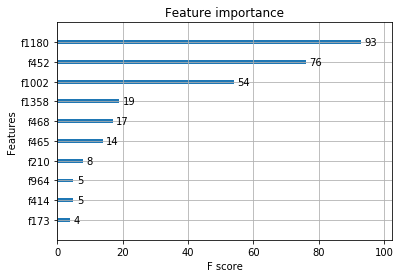

In [45]:
xgb.plot_importance(model, max_num_features=10)